###### Alzheimers Predictor

author: Simon Lee (siaulee@ucsc.edu)<br>
advisors: Razvan Marinescu, Vanessa Jonsson <br>
          
Objective: Taking data from ADNI, we would like to visualize the brain structure based off of 3T MRI Images and see whether someone will develop Alzheimer's disease based off of this temporal data. Image reconstruction is useful due to properly trying to diagnose diseases like Alzheimers disease and find early indicators that might lead to future developments.

In [1]:
# Import all external libraries for the project

import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from pylab import imread,subplot,imshow,show
import cv2
import os

#### STEP 1: Build training, testing and validation sets

In [2]:
train = ImageDataGenerator(rescale=1./255)
test =  ImageDataGenerator(rescale=1./255)
val =  ImageDataGenerator(rescale=1./255)

In [3]:
train='mri_data_png/train/'

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='training',
    seed=1000 )

Found 1959 files belonging to 3 classes.
Using 1568 files for training.


In [5]:
#val='mri_data_png/train/'

In [6]:
'''
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )
'''

Found 1959 files belonging to 3 classes.
Using 391 files for validation.


In [7]:
test='mri_data_png/test/'

In [8]:
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test,
    image_size=(224,224),
    batch_size=32,
    seed=1000
    )

Found 419 files belonging to 3 classes.


In [9]:
class_names = ['control (CN)', 'mild cognitive impairment (MCI)', "Alzheimer's disease (AD)"]

In [10]:
train_data.class_names = class_names
val_data.class_names = class_names
print(val_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


(32, 224, 224, 3)


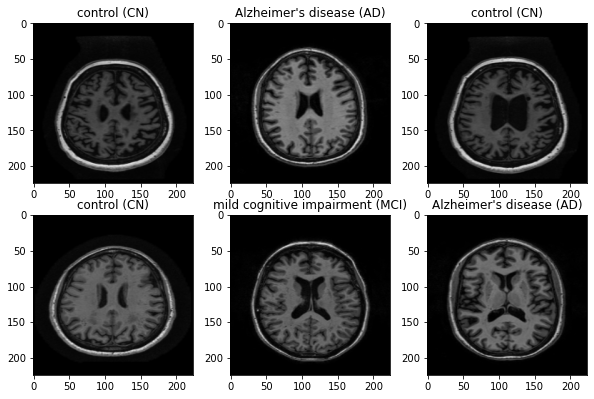

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    print(images.shape)
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]])
plt.savefig('data/data_vis.png')

### STEP 2: Understanding our Data Statistics

In [12]:
import numpy as np
import sklearn as sk
import pandas as pd
from SVDmodel import prediction
import os

In [13]:
# first read in dataset and display below
data = pd.read_csv('ADNI1_Annual_2_Yr_3T_4_21_2022.csv')

# remove all N/A
data = data.dropna()

data

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I40657,002_S_0413,CN,F,76,2,MRI,MPR; ; N3; Scaled,Processed,5/19/2006,NiFTI,4/19/2022
1,I64551,002_S_0413,CN,F,77,4,MRI,MPR; ; N3; Scaled,Processed,6/01/2007,NiFTI,4/19/2022
2,I118675,002_S_0413,CN,F,76,2,MRI,MPR; ; N3; Scaled_2,Processed,5/19/2006,NiFTI,4/19/2022
3,I120746,002_S_0413,CN,F,79,6,MRI,MPR; ; N3; Scaled,Processed,7/31/2008,NiFTI,4/19/2022
4,I45126,002_S_0559,CN,M,79,2,MRI,MPR; ; N3; Scaled,Processed,6/27/2006,NiFTI,4/19/2022
...,...,...,...,...,...,...,...,...,...,...,...,...
301,I119735,136_S_0579,MCI,F,66,2,MRI,MPR-R; ; N3; Scaled_2,Processed,7/10/2006,NiFTI,4/19/2022
302,I83554,136_S_0579,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,6/25/2007,NiFTI,4/19/2022
303,I143856,136_S_1227,MCI,F,67,6,MRI,MPR; ; N3; Scaled,Processed,3/23/2009,NiFTI,4/19/2022
304,I99265,136_S_1227,MCI,F,66,4,MRI,MPR; ; N3; Scaled,Processed,3/06/2008,NiFTI,4/19/2022


#### AGE

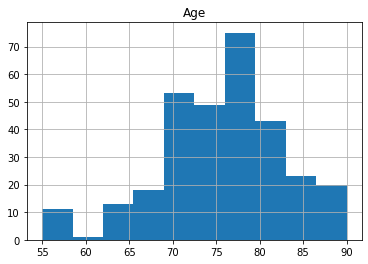

count    306.000000
mean      75.467320
std        7.058578
min       55.000000
25%       72.000000
50%       76.000000
75%       80.000000
max       90.000000
Name: Age, dtype: float64


In [14]:
data.hist(column='Age')
plt.savefig('data/demographic.png')
plt.show()
print(data['Age'].describe())

#### Sample Count

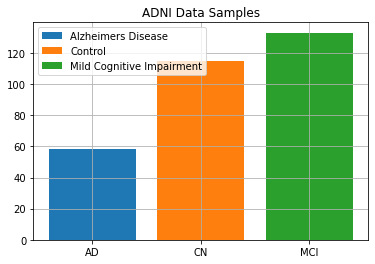

count     306
unique      3
top       MCI
freq      133
Name: Group, dtype: object


In [15]:
AD_count = 0
CN_count = 0
MCI_count = 0

# count the samples in our dataset
for i in data['Group']:
    if i == 'AD':
        AD_count += 1
    if i == 'CN':
        CN_count += 1
    if i == 'MCI':
        MCI_count += 1
plt.bar('AD', AD_count, label = 'Alzheimers Disease')
plt.bar('CN', CN_count, label = 'Control')
plt.bar('MCI', MCI_count, label = 'Mild Cognitive Impairment')
plt.title("ADNI Data Samples")
plt.legend()
plt.grid()
plt.savefig('data/sample_count.png')
plt.show()
    
print(data['Group'].describe())

#### Sex

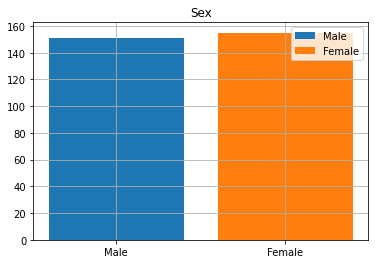

count     306
unique      2
top         F
freq      155
Name: Sex, dtype: object


In [16]:
M_count = 0
F_count = 0

for i in data['Sex']:
    if i == 'M':
        M_count += 1
    if i == 'F':
        F_count += 1

plt.title("Sex")
plt.bar('Male', M_count, label = 'Male')
plt.bar('Female', F_count, label = 'Female')
plt.legend()
plt.grid()
plt.savefig('data/sex_count.png')
plt.show()

print(data['Sex'].describe())


# STEP 3: Building the Convolutional Neural Network & Training

### Loss Function: sparse_categorical_crossentropy

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.layers import Dense

In [18]:
model=Sequential()

In [19]:
# The CNN architecture
model.add(Conv2D(16,(3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(12,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(133,activation='relu'))
model.add(Dense(4,activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [21]:
# Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [22]:
history = model.fit(train_data, validation_data=val_data, epochs=12)

Epoch 1/12
49/49 [==============================] - 22s 443ms/step - loss: 1.0240 - accuracy: 0.5077 - val_loss: 0.9609 - val_accuracy: 0.5115
Epoch 2/12
49/49 [==============================] - 22s 455ms/step - loss: 0.8596 - accuracy: 0.6052 - val_loss: 0.7555 - val_accuracy: 0.6726
Epoch 3/12
49/49 [==============================] - 22s 443ms/step - loss: 0.6515 - accuracy: 0.7073 - val_loss: 0.6773 - val_accuracy: 0.7136
Epoch 4/12
49/49 [==============================] - 23s 460ms/step - loss: 0.6430 - accuracy: 0.7117 - val_loss: 0.5277 - val_accuracy: 0.7596
Epoch 5/12
49/49 [==============================] - 22s 449ms/step - loss: 0.4265 - accuracy: 0.7742 - val_loss: 0.5166 - val_accuracy: 0.7954
Epoch 6/12
49/49 [==============================] - 22s 444ms/step - loss: 0.3379 - accuracy: 0.8705 - val_loss: 0.3085 - val_accuracy: 0.8849
Epoch 7/12
49/49 [==============================] - 22s 448ms/step - loss: 0.2626 - accuracy: 0.9075 - val_loss: 0.4483 - val_accuracy: 0.8210

In [23]:
model.save("alz_model1.h5")

In [24]:
model.evaluate(val_data)
test_set = 419

13/13 [==============================] - 2s 125ms/step - loss: 0.0634 - accuracy: 0.9770


# Plotting model statistics

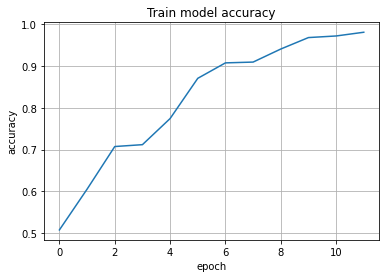

In [25]:
plt.plot(history.history['accuracy'])
plt.title('Train model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()

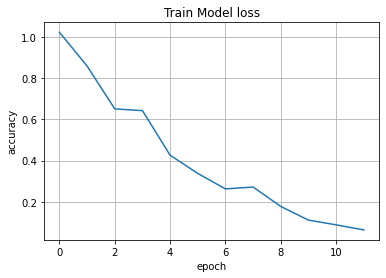

In [26]:
plt.plot(history.history['loss'])
plt.title('Train Model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()

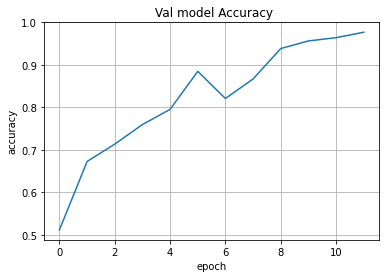

In [27]:
plt.plot(history.history['val_accuracy'])
plt.title(' Val model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()

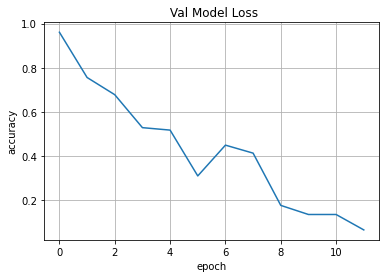

In [28]:
plt.plot(history.history['val_loss'])
plt.title(' Val Model Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()

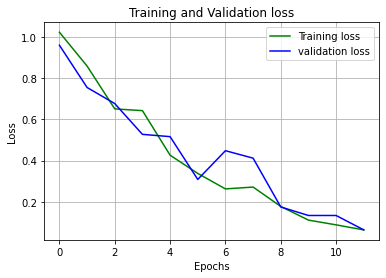

In [29]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('data/loss.png')
plt.show()

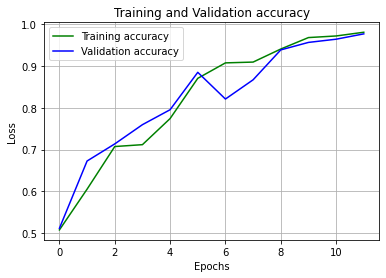

In [30]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('data/accuracy.png')
plt.show()

# STEP 4: Prediction works

In [31]:
class_names={0:"CN", 1:"MCI", 2:"AD"}

#### First on Validation data

True_class: control (CN)
Predicted Image: CN
Predicted class: 0
True_class: Alzheimer's disease (AD)
Predicted Image: AD
Predicted class: 2
True_class: mild cognitive impairment (MCI)
Predicted Image: MCI
Predicted class: 1
True_class: Alzheimer's disease (AD)
Predicted Image: AD
Predicted class: 2
True_class: mild cognitive impairment (MCI)
Predicted Image: MCI
Predicted class: 1
True_class: Alzheimer's disease (AD)
Predicted Image: AD
Predicted class: 2


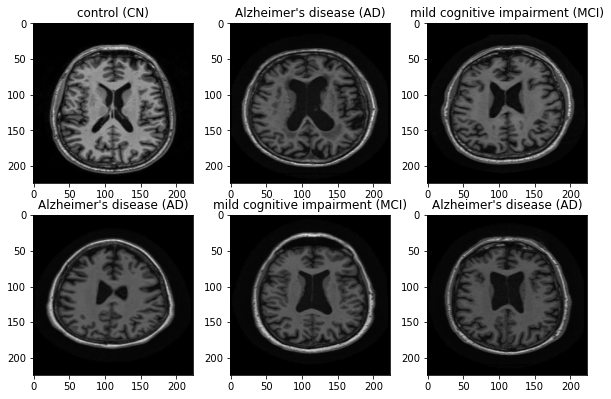

In [32]:

plt.figure(figsize=(10, 10))
# validation data 
for images, labels in val_data.take(1):
    for i in range(6):
        print("True_class:",val_data.class_names[labels[i]])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
    
        if p==0:
            print("Predicted Image: CN")
        elif p==1:
            print("Predicted Image: MCI")
        else:
            print("Predicted Image: AD")
        
        
        print("Predicted class:",p)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]])

#### Now on Test Data

In [33]:
plt.figure(figsize=(10, 10))
# validation data 
for images, labels in test_data.take(1):
    for i in range(1):
        print("True_class:", test_data.class_names[labels[i]])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        accuracy = prediction(test_set)

print()
print("Accuracy:", accuracy/test_set)
        

True_class: MCI
True_class: CN
Predicted Image: MCI
Predicted Class: 1
True_class: MCI
Predicted Image: AD
Predicted Class: 2
True_class: CN
Predicted Image: CN
Predicted Class: 0
True_class: AD
Predicted Image: MCI
Predicted Class: 1
True_class: AD
Predicted Image: CN
Predicted Class: 0
True_class: AD
Predicted Image: AD
Predicted Class: 2
True_class: AD
Predicted Image: CN
Predicted Class: 0
True_class: MCI
Predicted Image: AD
Predicted Class: 2
True_class: CN
Predicted Image: CN
Predicted Class: 0
True_class: AD
Predicted Image: MCI
Predicted Class: 1
True_class: AD
Predicted Image: MCI
Predicted Class: 1
True_class: AD
Predicted Image: MCI
Predicted Class: 1
True_class: AD
Predicted Image: MCI
Predicted Class: 1
True_class: MCI
Predicted Image: AD
Predicted Class: 2
True_class: AD
Predicted Image: CN
Predicted Class: 0
True_class: CN
Predicted Image: MCI
Predicted Class: 1
True_class: CN
Predicted Image: MCI
Predicted Class: 1
True_class: MCI
Predicted Image: CN
Predicted Class: 0


Predicted Image: CN
Predicted Class: 0
True_class: CN
Predicted Image: MCI
Predicted Class: 1
True_class: CN
Predicted Image: CN
Predicted Class: 0
True_class: AD
Predicted Image: CN
Predicted Class: 0
True_class: MCI
Predicted Image: MCI
Predicted Class: 1
True_class: CN
Predicted Image: CN
Predicted Class: 0
True_class: AD
Predicted Image: CN
Predicted Class: 0
True_class: MCI
Predicted Image: MCI
Predicted Class: 1
True_class: MCI
Predicted Image: MCI
Predicted Class: 1
True_class: MCI
Predicted Image: CN
Predicted Class: 0
True_class: CN
Predicted Image: AD
Predicted Class: 2
True_class: MCI
Predicted Image: CN
Predicted Class: 0
True_class: AD
Predicted Image: CN
Predicted Class: 0
True_class: AD
Predicted Image: AD
Predicted Class: 2
True_class: CN
Predicted Image: CN
Predicted Class: 0
True_class: CN
Predicted Image: CN
Predicted Class: 0
True_class: MCI
Predicted Image: MCI
Predicted Class: 1
True_class: CN
Predicted Image: CN
Predicted Class: 0
True_class: AD
Predicted Image: 

<Figure size 720x720 with 0 Axes>